## Demo Keyword Extraction aus E-Mail Daten

Dieses Notebook dient der Demonstration eines Algorithmus zur Keyword Extraction aus Textdaten. Es ist im Rahmen der Masterthesis von Christian Hiller entstanden. Bei Fragen und Anregungen: hich1023@h-ka.de

#### Beschreibung des Vorgehens

- Bereinigung der Texte
- Generierung eines Word Co-Occurrence Graphen
- Ermittlung von Keywords durch Berechnung von Graphmetriken

In [2]:
# beim ersten mal müssen eventuell einige libraries installiert werden
!pip install -r requirements.txt
!spacy download en_core_web_sm
!spacy download de_core_news_sm

In [1]:
import pandas as pd
import networkx as nx
import numpy as np
import spacy
import nltk

import en_core_web_sm
import de_core_news_sm
from nltk.stem.snowball import SnowballStemmer
import re

import textgraph
import textmetrics

### Nutzereingabe

Im folgenden Codefeld bitte den Pfad zu einer Datei angeben, deren Inhalt dem Format des Beispiels 'news.csv' entspricht: Durch **;** voneinander getrennte Texte.

Zusätzlich bitte die Sprache der Texte wie beschrieben angeben und eventuelle Wörter, die vom Algorithmus ignoriert werden sollen, in der Liste 'additional_stopwords' angeben.

In [3]:
# hier den Pfad zur csv-Datei angeben
PATH_texts = 'data/news.csv'

# hier die gewünschte Sprache angeben ('en' oder 'de')
language = 'de'

# hier Wörter hinzufügen, die ignoriert werden sollen
additional_stopwords = [
    'PLATZHALTER',
    'PLATZHALTER 2',
    '...'
]

## Die folgenden Codefelder einfach ausführen

#### Import der Daten und Laden von Modellen

In [4]:
if language == 'en':
    nlp = en_core_web_sm.load()
    stemmer = SnowballStemmer('english')

elif language == 'de':
    nlp = de_core_news_sm.load()
    stemmer = SnowballStemmer('german')
    
stopwords = nlp.Defaults.stop_words
stopwords = stopwords.union(set(additional_stopwords))

In [14]:
import random
texts = pd.read_csv(PATH_texts, header=None, sep=';')
texts = texts[0].to_list()
texts = random.sample(texts, 100) # Hier werden nur 100 zufällige Texte betrachtet. Dieses Zeile auskommentieren für alle.

#### Bereinigung der Texte

Vor der Generierung des Graphen werden die Texte bereinigt. Das umfasst folgende Schritte:

- Konvertierung zu Kleinschreibung
- Entfernen von Satzzeichen, einzelner Buchstaben, URLs, Absätzen und Zeilenumbrüchen
- Entfernen so genannter Stopwords (sehr häufig auftretende Wörter mit i.d.R. keinem Mehrwert für Informationsgewinnung)
- Reduktion von Wörtern auf ihren Wortstamm (z.B. *gesehen* und *sah* werden zu *seh*)

In [6]:
# Die Texte werden bereinigt und in Tokens zerlegt
texts_tokenized = textgraph.clean_texts(texts=texts, stopwords=stopwords, stemmer=stemmer) # bei Bedarf Stemmer übergeben

Convert to lowercase
Remove words that start with HTTP
Remove words that start with WWW
Remove punctuation
Remove words made of single letters
Remove stopwords
Remove additional whitespaces
Remove Linebreaks
Tokenize text documents (becomes a list of lists)
Stemming


#### Generierung des Word Co-Occurrence Graph

Aus den Inhalten der Texte wird ein Graph generiert.
- **Knoten:** Wort aus den Texten
- **Kante:** Wort A und Wort B kommen im selben Text vor
- **Kantengewicht:** Anzahl der Texte, in denen Wort A und B gemeinsam vorkommen
- **link_filter:** Mindestanzahl Kantengewicht zur Berücksichtigung der Verbindung

der Linkfilter kann nach Bedarf angepasst werden.

In [7]:
G = textgraph.create_wcn(texts=texts_tokenized, link_filter=4)

Original Network
No. of Nodes: 2019 No. of Edges: 108326
Filtered Network
No. of Nodes: 1417 No. of Edges: 5394


#### Berechnung von Graphmetriken

Es werden folgende Metriken berechnet:
- **Prevalence:** relative Häufigkeit eines Wortes über alle Texte
- **Diversity:** Gradzentralität eines Knoten im Graph mit Bestrafungkoeffizient für besonders stark vernetzte Knoten
- **Connectivity:** Betweennesszentralität eines Wortes

Die Metriken werden pro Wort / Knoten berechnet und anschließend standardisiert. Jede dieser Metriken kann als die Wichtigkeit eines Wortes in den eingegebenen Texten gesehen werden. Eine Interpretation folgt bei der Betrachtung der Ergebnisse.

In [8]:
metrics = textmetrics.calculateTextMetrics(G, texts_tokenized, parallel=True)

### Ergebnisbetrachtung

In [9]:
# Anzahl der Top X Elemente, sortiert nach Connectivity
n_top = 20

In [10]:
metrics.iloc[:n_top,:].sort_values(by='connectivity', ascending=False)

,prevalence,diversity,connectivity
arbeitslos,6.537430,10.028181,11.540214
million,9.690576,5.420515,11.428006
irak,5.906801,12.486768,10.770741
euro,9.059947,3.334676,10.762041
–,11.582464,4.875334,10.384359
kandidat,6.537430,8.978640,9.900368
hoh,7.168059,5.188519,9.466704
standard,8.429318,11.627580,8.540147
deutsch,7.798688,7.133338,8.465845
sprach,4.645542,4.983683,7.550848


#### Interpretationshinweise

**Prevalence:**

Je häufiger ein Wort, verglichen mit anderen Wörtern, in den Texten vorkommt, umso wichtiger ist es.

**Diversity:**

Ein Wort mit einer hohen Diversity kommt zusammen mit vielen verschiedenen, weniger stark vernetzten Wörtern vor. Das Wort steht vermutlich im Kontext zu mehreren verschiedenen Themen. Viele Verbindungen zu **stark vernetzten** Wörtern wirken sich negativ auf die Diversität aus. 

**Connectivity:**

Ein Wort mit hoher Connectivity steht sehr zentral in der Kommunikation und verbindet viele andere Wörter miteinander. Das Wort ist vermutlich textübergreifend sehr wichtig. Hier wird die Verbindung zu stark vernetzten Begriffen nicht bestraft.

### Darstellung des Graphen

Eine Visualisierung des gesamten Graphen führt in der Regel zu keinem Erkenntnisgewinn, da das sehr unübersichtlich ist. Es wird daher empfohlen, die Nachbarschaft eines für den Anwender interessanten Wortes zu betrachten. Zur Darstellung eines Wortes und seiner Nachbarschaft im folgenden die Variable **node** mit dem gewünschten Wort belegen.

**Hinweis:**
Die Übersichtlichkeit des Graph hängt stark von der Anzahl und der Länge der Texte ab. Die Parameter **radius** und **min_weight** können angepasst werden, um die übersichtlichkeit zu verbessern.
- **radius:** Nachbarschaft X-ten Grades eines Nodes wird angezeigt (z.B. radius=2 -> direkte Nachbarn des Knoten und deren Nachbarn).
- **min_weight:** Nur Kanten mit einem Gewicht von mindestens X werden angezeigt.

**Legende:**
- roter Knoten: das betrachtete Wort
- grüne Knoten: Nachbarn des roten Knoten mit Kantengewicht > min_weight
- blaue Knoten: Nachbarn des roten Knoten mit Kantengewicht < min_weight

No. of Nodes: 16 No. of Edges: 36


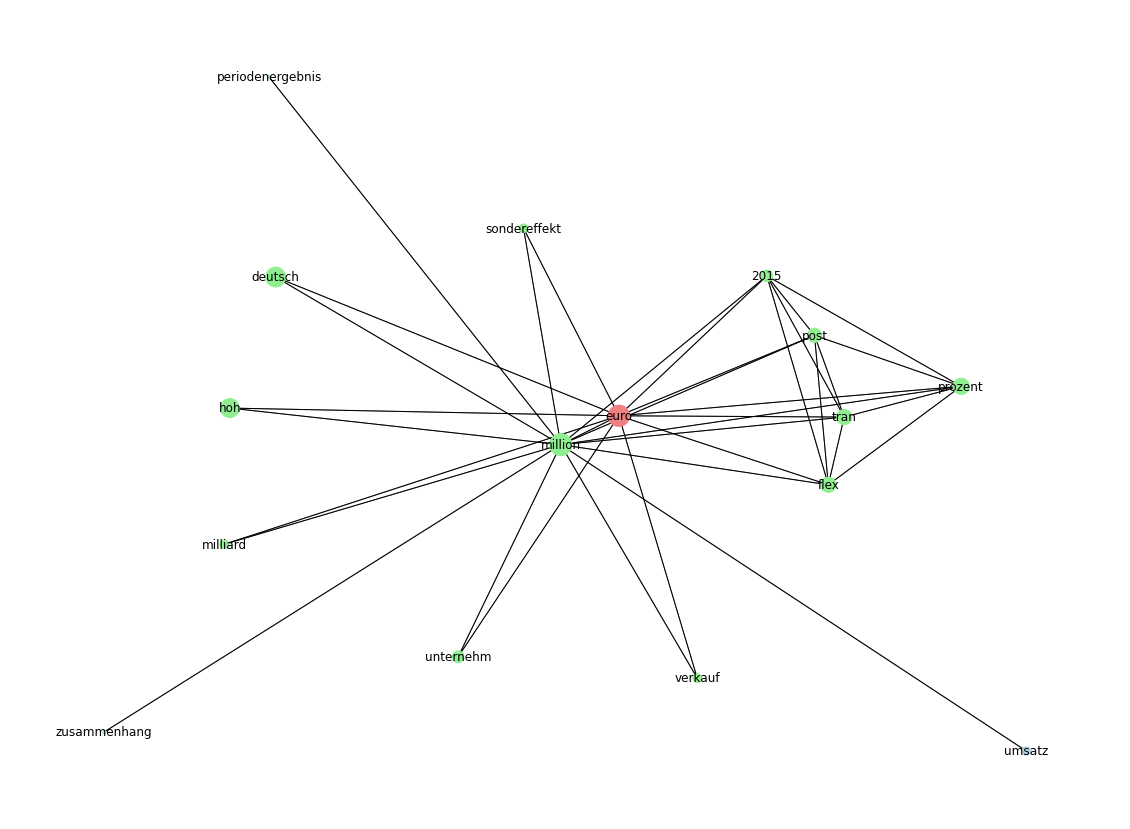

In [13]:
node = 'euro'
textgraph.show_ego_of_word(G=G, node=node, radius=1, min_weight=20)

Die Kanten in dieser Darstellung wirken wie mechanische Federn. Je stärker das Gewicht der Kanten, desto näher sind die Knoten beieinander.